In [265]:
import pickle
import gzip
import numpy as np
import random
import pickle 
import matplotlib.pyplot as plt
import math

def load_data():
    with gzip.open("../data/mnist.pkl.gz", "rb") as file:
        train, val, test = pickle.load(file, encoding="latin1")
    return train, val, test

def load_data_wrapper():
    train, val, test = load_data()
    
    train_inputs = [np.reshape(x, (784, 1)) for x in train[0]]
    train_outputs = [one_hot_encode(y, 10) for y in train[1]]
    train_data = list(zip(train_inputs, train_outputs))
    
    val_inputs = [np.reshape(x, (784, 1)) for x in val[0]]
    val_data = list(zip(val_inputs, val[1]))
    
    test_inputs = [np.reshape(x, (784, 1)) for x in test[0]]
    test_data = list(zip(test_inputs, test[1]))
    
    return train_data, val_data, test_data

def one_hot_encode(y, num_categories):
    one_hot = np.zeros((num_categories, 1))
    one_hot[y] = 1
    return one_hot

In [266]:
def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))

def sigmoid_derivative(z):
    return sigmoid(z)*(1-sigmoid(z))

In [267]:
train, val, test = load_data_wrapper()

In [423]:
class NetworkVectorized(object):
    def __init__(self, sizes):
        """sizes: list of ints signifying size of each layer, including the input and output layers"""
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(next_h, prev_h) 
                        for next_h, prev_h in zip(sizes[1:],sizes[:-1])]
    
    def feedforward(self, a):
        """roughly 3 times faster than for-loop version"""
        for w, b in zip(self.weights, self.biases):
            a = sigmoid(np.dot(w, a)+b)
        return a
    
    
    def SGD(self, train_data, epochs, batch_size, learning_rate, test_data=None):
        if test_data:
            n_test = len(test_data)
        n_train = len(train_data)
        
        for i in range(epochs):
            random.shuffle(train_data)
            mini_batches = [train_data[j:j+batch_size] for j in range(0, n_train, batch_size)]
            
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, learning_rate)
            
            if test_data:
                print(f"Epoch {i}: {self.evaluate(test_data)} / {n_test}")
                
            else:
                print(f"Epoch {i}: complete")
                
                
    def update_mini_batch(self, mini_batch, learning_rate):
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        
        x = np.asarray([_x.ravel() for _x, _y in mini_batch]).transpose()
        y = np.asarray([_y.ravel() for _x, _y in mini_batch]).transpose()
        
        delta_nabla_b, delta_nabla_w = self.backprop(x, y)
        
        nabla_b = [nb+dnb for nb, dnb in zip(nabla_b,delta_nabla_b)]
        nabla_w = [nw+dnw for nw, dnw in zip(nabla_w,delta_nabla_w)]
        
        self.weights = [w -(learning_rate/len(mini_batch))*nw 
                        for w, nw in zip(self.weights, nabla_w)]    
        self.biases = [b -(learning_rate/len(mini_batch))*nb 
                        for b, nb in zip(self.biases, nabla_b)]
        
        
    def backprop(self, x, y):
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        
        # Forward pass 
        activation = x      
        activations = [x]   
        zs = []      
        for w, b in zip(self.weights, self.biases):
            z = w.dot(activation) + b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
            
        # Backward pass 
        dloss = self.MSE_derivative(activations[-1], y)
        dz = dloss * sigmoid_derivative(zs[-1])

        nabla_b[-1] = np.sum(dz, axis=1, keepdims=True)
        nabla_w[-1] = dz.dot(activations[-2].T)
            
        for l in range(2, self.num_layers):
            z = zs[-l]
            d_sigmoid = sigmoid_derivative(z)
            dz = self.weights[-l+1].T.dot(dz) * d_sigmoid
            nabla_b[-l] = np.sum(dz, axis=1, keepdims=True)
            nabla_w[-l] = dz.dot(activations[-l-1].T)
        
        return nabla_b, nabla_w
    

    def MSE_derivative(self, activation, y):
        return activation - y
    
    
    def evaluate(self, test_data):
        x = np.asarray([x.ravel() for x, _ in test_data]).T
        y = np.asarray([_y.ravel() for _x, _y in test_data])
        preds = np.argmax(self.feedforward(x), axis=0)
        return sum(x == y for x, y in zip(preds, y))
    
    
    def get_activations_for_example(self, x):
        activations = [x]
        a = x
        for w, b in zip(self.weights, self.biases):
            a = sigmoid(np.dot(w, a)+b)
            activations.append(a)
        return activations
    
    def plot_first_layer_weights(self, name=None):
        fig=plt.figure(figsize=(8,8))
        w_h, w_w = net.weights[0].shape
        fig_cols = math.floor(math.sqrt(w_h))
        fig_rows = math.ceil(w_h/fig_cols)
                
        for i in range(w_h):
            img = np.reshape(self.weights[0][i], (28, 28))    
            fig.add_subplot(fig_rows, fig_cols, i+1)
            plt.imshow(img, interpolation='nearest')
        fig.suptitle(f'First Layer Weights', fontsize=20)
        
        if name:
            fig.savefig(f"{name}.png")

In [436]:
net = NetworkVectorized([784, 9, 10])

In [433]:
net.SGD(train_data=train, epochs=30, batch_size=40, learning_rate=3.0, test_data=test)

Epoch 0: [9050] / 10000
Epoch 1: [9073] / 10000
Epoch 2: [9109] / 10000
Epoch 3: [9096] / 10000
Epoch 4: [9120] / 10000
Epoch 5: [9122] / 10000
Epoch 6: [9148] / 10000
Epoch 7: [9132] / 10000
Epoch 8: [9173] / 10000
Epoch 9: [9098] / 10000
Epoch 10: [9159] / 10000
Epoch 11: [9152] / 10000
Epoch 12: [9144] / 10000
Epoch 13: [9167] / 10000
Epoch 14: [9129] / 10000
Epoch 15: [9157] / 10000
Epoch 16: [9126] / 10000
Epoch 17: [9114] / 10000
Epoch 18: [9170] / 10000
Epoch 19: [9155] / 10000
Epoch 20: [9124] / 10000
Epoch 21: [9153] / 10000
Epoch 22: [9139] / 10000
Epoch 23: [9134] / 10000
Epoch 24: [9143] / 10000
Epoch 25: [9167] / 10000
Epoch 26: [9194] / 10000
Epoch 27: [9179] / 10000
Epoch 28: [9185] / 10000
Epoch 29: [9171] / 10000


In [370]:
dz = np.random.randn(30, 20)
a = np.random.randn(784, 20)

In [238]:
dz.dot(a.T).shape

(30, 784)

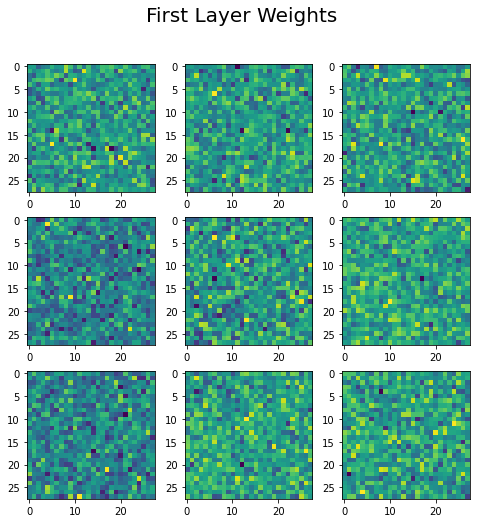

In [437]:
net.plot_first_layer_weights("untrained")